In [1]:
# 导入相关库
import numpy as np
import pandas as pd
import pytz
import rqdatac
import datetime as dt
import matplotlib.pyplot as plt
import os

start_date = 20150101
end_date = dt.datetime.now(pytz.timezone("Asia/Shanghai")).strftime("%Y%m%d")

rqdatac.init()

T_df = rqdatac.futures.get_dominant_price(
    underlying_symbols="T",
    start_date=start_date,
    end_date=end_date,
    frequency="1d",
    fields=None,
    adjust_type="pre",
    adjust_method="prev_close_spread",
)

TF_df = rqdatac.futures.get_dominant_price(
    underlying_symbols="TF",
    start_date=start_date,
    end_date=end_date,
    frequency="1d",
    fields=None,
    adjust_type="pre",
    adjust_method="prev_close_spread",
)

d:\gitrepo\FICC_QIS\venv\Lib\site-packages\rqdatac\client.py:257: UserWarning: Your account will be expired after  13 days. Please call us at 0755-22676337 to upgrade or purchase or renew your contract.
  warnings.warn("Your account will be expired after  {} days. "


In [2]:
T_prices = (T_df["open"] + T_df["close"]) / 2
TF_prices = (TF_df["open"] + TF_df["close"]) / 2

# 基点价值计算（久期近似值）
T_BPV = 7.5 / 100 * 1_000_000
TF_BPV = 4.5 / 100 * 1_000_000
BPV_ratio = T_BPV / TF_BPV

spread_df = pd.DataFrame(
    {
        "TF_prices": TF_prices.droplevel(level=0),
        "T_prices": T_prices.droplevel(level=0),
        "BPV_ratio": BPV_ratio,
    }
)

# 计算价差
spread_df["T-2TF"] = TF_prices.droplevel(level=0) - 2 * TF_prices.droplevel(level=0) / BPV_ratio

# 计算移动均值和标准差
window = 20
spread_df["MEAN"] = spread_df["T-2TF"].rolling(window=window, min_periods=1).mean()
spread_df["SD"] = spread_df["T-2TF"].rolling(window=window, min_periods=1).std()
spread_df["Z_SCORE"] = (spread_df["T-2TF"] - spread_df["MEAN"]) / spread_df["SD"]

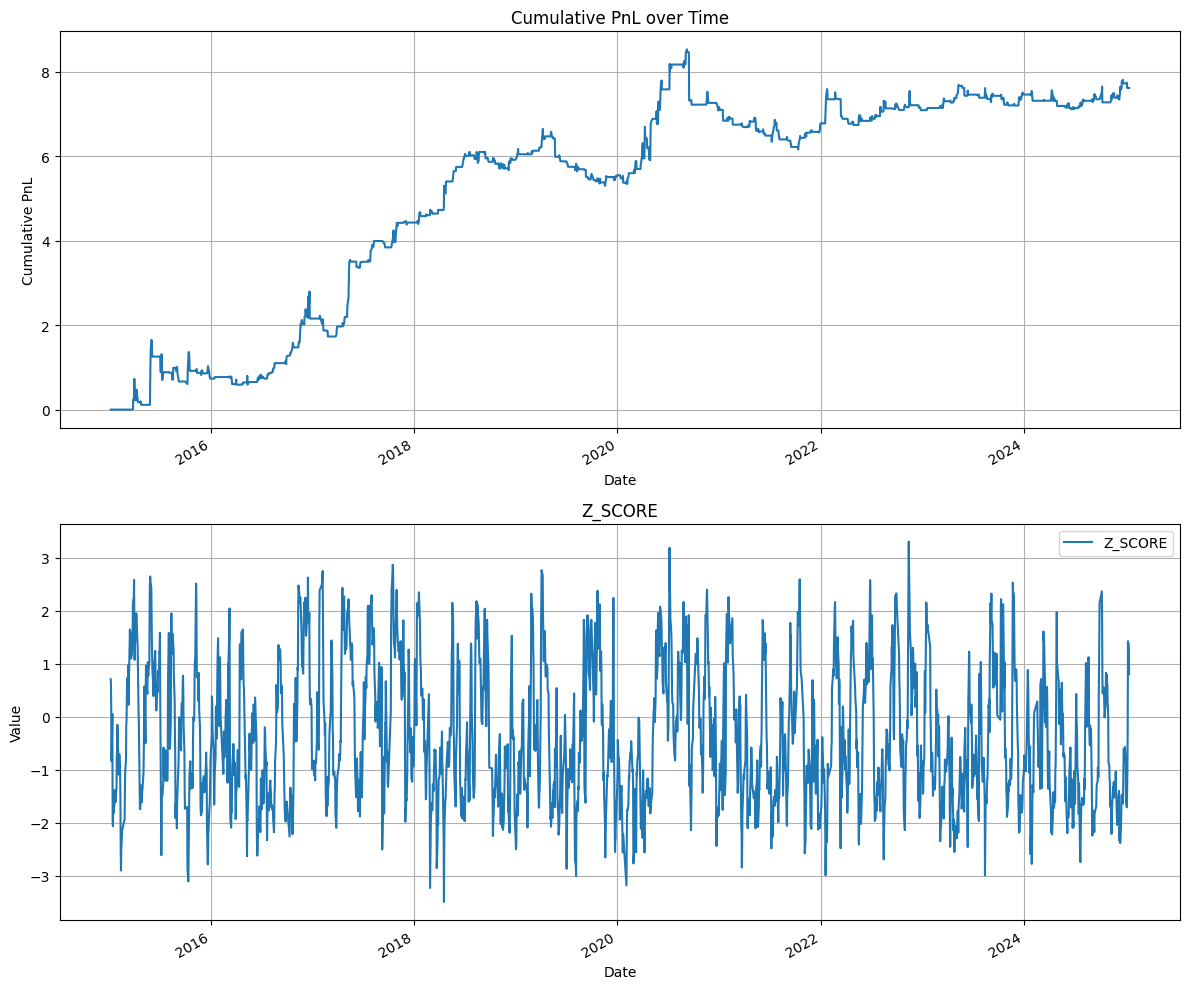

In [3]:
# 初始化持仓状态
spread_df["POSITION_T"] = 0
spread_df["POSITION_TF"] = 0
# 记录每日持仓和盈亏
spread_df["PNL"] = 0
spread_df["CUM_PNL"] = 0

# 策略调整
entry_threshold = 1.5
exit_threshold = 1

for i in range(len(spread_df)):
    if spread_df.iloc[i]["Z_SCORE"] < -entry_threshold:
        # 价差过大，卖出T，买入两手TF
        spread_df.at[spread_df.index[i], "POSITION_T"] += -1
        spread_df.at[spread_df.index[i], "POSITION_TF"] += 2
    elif spread_df.iloc[i]["Z_SCORE"] > entry_threshold:
        # 价差过小，买入T，卖出两手TF
        spread_df.at[spread_df.index[i], "POSITION_T"] += 1
        spread_df.at[spread_df.index[i], "POSITION_TF"] += -2
    # elif abs(spread_df.iloc[i]["Z_SCORE"]) <= exit_threshold:
    #     # 价差回归，平仓
    #     spread_df.at[spread_df.index[i], "POSITION_T"] = 0
    #     spread_df.at[spread_df.index[i], "POSITION_TF"] = 0

    # 计算当日盈亏
    if i > 0:
        position_T = spread_df.iloc[i - 1]["POSITION_T"]
        position_TF = spread_df.iloc[i - 1]["POSITION_TF"]
        daily_pnl = position_T * (spread_df.iloc[i]["T_prices"] - spread_df.iloc[i - 1]["T_prices"]) + position_TF * (
            spread_df.iloc[i]["TF_prices"] - spread_df.iloc[i - 1]["TF_prices"]
        )
        spread_df.at[spread_df.index[i], "PNL"] = daily_pnl
        spread_df.at[spread_df.index[i], "CUM_PNL"] = spread_df.iloc[: i + 1]["PNL"].sum()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot Cumulative PnL
spread_df["CUM_PNL"].plot(ax=ax1)
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative PnL")
ax1.set_title("Cumulative PnL over Time")
ax1.grid(True)

# Plot Z_SCORE
spread_df["Z_SCORE"].plot(ax=ax2, label="Z_SCORE")
ax2.set_xlabel("Date")
ax2.set_ylabel("Value")
ax2.set_title("Z_SCORE")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
# Create directory if it doesn't exist
os.makedirs(os.path.join(".", "plot"), exist_ok=True)
plt.savefig(os.path.join(".", "plot", "T_2TF.png"))
plt.show()